In [1]:
import paco.processing.paco as p
import paco.processing.fullpaco as f_paco
from paco.util.util import *
import cv2 as cv2

import numpy as np
import matplotlib.pyplot as plt

fp = f_paco.FullPACO(patch_size = 5)

Text(0.5, 1.0, '0 deg rotation')

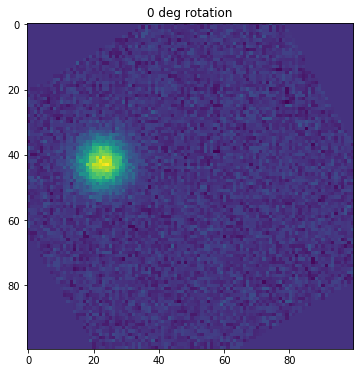

In [2]:
angles = np.array([0, 30, 45, 60, 90])
p0 = (30,30)
sigma = 0.5 # gaussian noise

mean = 0

images = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(len(angles))]

xx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))
s = gaussian2d(xx,yy,10, 5)
images_signal = [i + s for i in images]
rot_images = np.array([rotateImage(images_signal[j], angles[j]) for j in range(len(images_signal))])
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.imshow(rot_images[1])
ax.set_title("0 deg rotation")




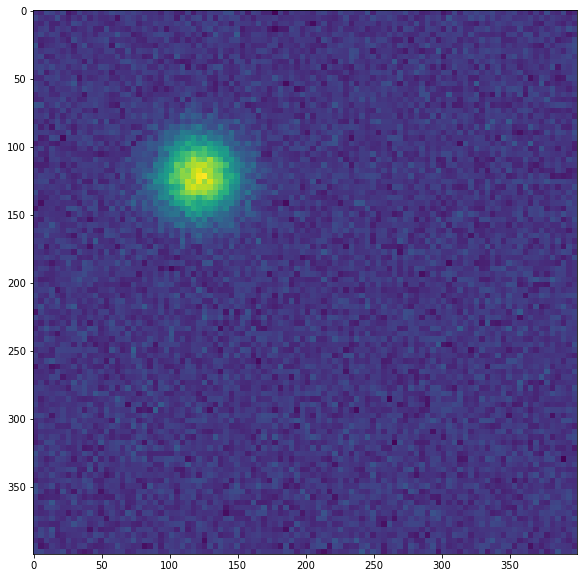

In [3]:
SCALE_FACTOR = 4

#image = imresize(rot_images[0],
#                (SCALE_FACTOR *rot_images[0].shape[0], SCALE_FACTOR * rot_images[0].shape[1]), 
#                interp = 'bilinear', 
#                mode = 'F')
#myImage = Image.fromarray(rot_images[0]).resize((SCALE_FACTOR *rot_images[0].shape[0], 
#                                                        SCALE_FACTOR * rot_images[0].shape[1]),
#                                                       resample = Image.NEAREST)

myImage = cv2.resize(rot_images[0],(0,0), fx = SCALE_FACTOR, fy = SCALE_FACTOR, interpolation = cv2.INTER_NEAREST)
plt.figure(figsize=(20,10))
plt.imshow(myImage)

In [ ]:
fp.set_image_sequence(rot_images)
phi0s = np.array([[30,30]])
a,b = fp.PACO(angles)
#a,b = fp.PACO_calc(phi0s,angles)
#a,b= fp.PACO(phi0s,angles)

Running PACO...


In [ ]:
print(a,b)
img = b/np.sqrt(a)
plt.imshow(img)
plt.colorbar()